<a href="https://colab.research.google.com/github/AliTarek-1/AliTarek-1/blob/main/CVPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

No periodic sinusoidal wave patterns detected. Using Otsu's method.
Rotation angle: 0.0


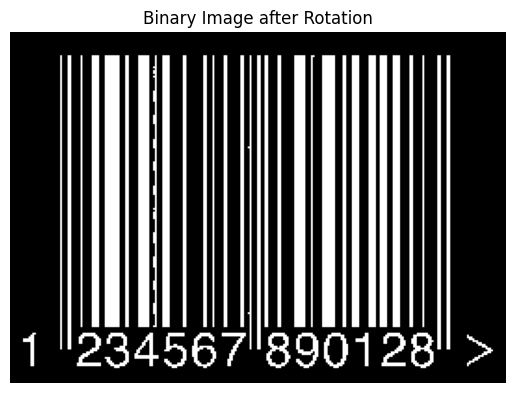

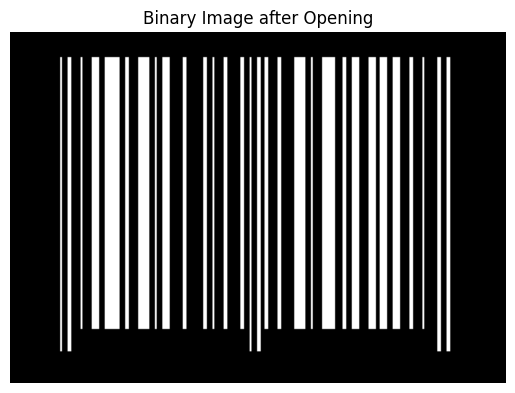

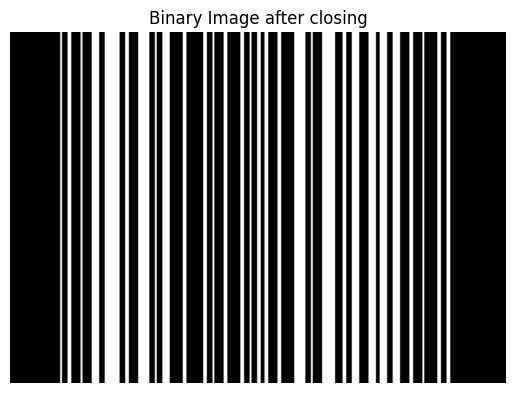

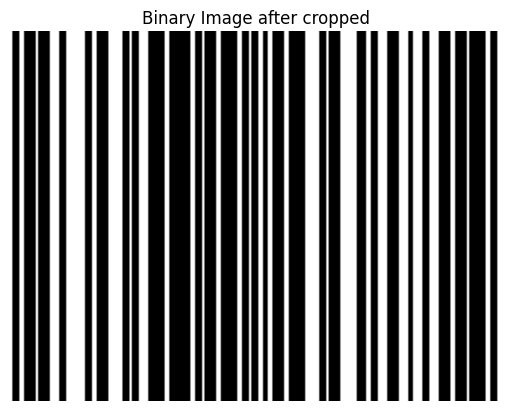

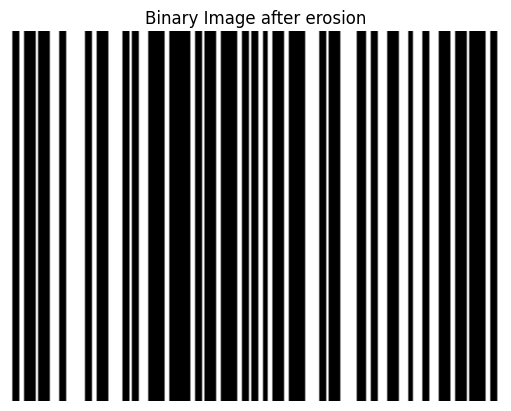

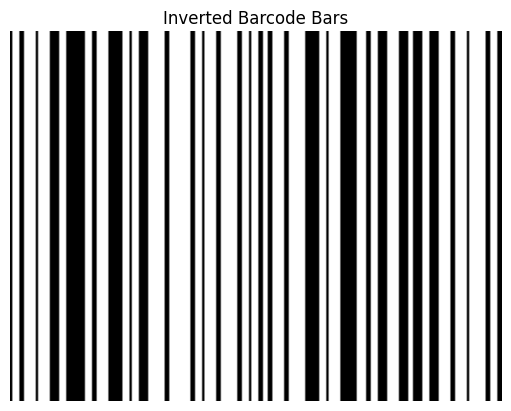

In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

def detect_large_slices_from_dft(binary_image):
    """
    Apply DFT to detect periodic vertical or horizontal slices in the binary image.
    """
    # Apply 2D Fourier Transform to the binary image
    dft = cv2.dft(np.float32(binary_image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift the zero-frequency component to the center

    # Get the magnitude spectrum of the DFT (log scale for better visibility)
    magnitude_spectrum = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
    log_magnitude = np.log(1 + magnitude_spectrum)

    # Find the peak in the frequency domain (this will correspond to the periodicity of large slices)
    rows, cols = binary_image.shape
    crow, ccol = rows // 2, cols // 2  # center of the image

    # Create a mask to highlight low-frequency components (periodicity detection)
    magnitude_spectrum[crow - 30:crow + 30, ccol - 30:ccol + 30] = 0  # Remove the center to detect periodicity

    # Sum across rows and columns to find the dominant frequencies
    vertical_projection = np.sum(magnitude_spectrum, axis=0)
    horizontal_projection = np.sum(magnitude_spectrum, axis=1)

    # Check if there are large periodic slices (large peaks in projection)
    vertical_peak = np.max(vertical_projection)
    horizontal_peak = np.max(horizontal_projection)

    # Compute the total length of the projection to determine if it spans most of the image
    vertical_proportion = np.sum(vertical_projection > 0.5 * vertical_peak) / cols
    horizontal_proportion = np.sum(horizontal_projection > 0.5 * horizontal_peak) / rows

    # Define thresholds for detecting large slices
    vertical_threshold = 0.2  # Proportion of image width
    horizontal_threshold = 0.2  # Proportion of image height

    # Check for large slices (covering a significant portion of the image)
    if (vertical_peak > 1 * np.mean(vertical_projection) and vertical_proportion > vertical_threshold) or \
       (horizontal_peak > 1 * np.mean(horizontal_projection) and horizontal_proportion > horizontal_threshold):
        return True  # Large periodic slices detected

    return False  # No large periodic slices detected

def extract_bars_with_erosion(input_path, output_path):
    image = cv2.imread(input_path)
    if image is None:
        raise ValueError("Error: Unable to load image.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Detect sinusoidal patterns


    if detect_large_slices_from_dft(binary):
        print("Periodic sinusoidal wave patterns detected. Applying adaptive thresholding.")
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)
        #_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        print("No periodic sinusoidal wave patterns detected. Using Otsu's method.")
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


    # # Visualization
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    # ax1.imshow(image, cmap='gray')
    # ax1.set_title("Original Image")
    # ax2.imshow(spectrum, cmap='gray')
    # ax2.set_title("Magnitude Spectrum")
    # ax3.imshow(binary, cmap='gray')
    # ax3.set_title("Processed Binary Image")
    # plt.show()

    # Detect and correct the orientation of the barcode
    coords = np.column_stack(np.where(binary > 0))
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]
    print(f"Rotation angle: {angle}")
    if angle != 90:
        angle = -angle
        (h, w) = binary.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        binary = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        coords = np.column_stack(np.where(binary > 0))
        rect = cv2.minAreaRect(coords)

    # Keep a copy of the binary image before dilation or height-increasing operations
    original_binary = binary.copy()







    # Visualize the binary image after rotation
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Image after Rotation")
    plt.axis('off')
    plt.show()

    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel)


    # Visualize the binary image after opening
    plt.imshow(vertical_lines, cmap='gray')
    plt.title("Binary Image after Opening")
    plt.axis('off')
    plt.show()


    # # Find the bounding box of the bars
    # x, y, w, h = cv2.boundingRect(vertical_lines)
    # # Crop the image to the bounding box
    # cropped = vertical_lines[y:y + h, x:x + w]

    # # Visualize the binary image after cropping
    # plt.imshow(cropped, cmap='gray')
    # plt.title("Binary Image after cropped")
    # plt.axis('off')
    # plt.show()

    # cropped=extract_bars_c(vertical_lines)

    #dilation_kernel=cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60))
    #dilation=cv2.dilate(vertical_lines, dilation_kernel, iterations=10)

    closing_kernel=cv2.getStructuringElement(cv2.MORPH_RECT, (1, 20))
    closing=cv2.morphologyEx(vertical_lines, cv2.MORPH_CLOSE, closing_kernel, iterations=40)

    # Visualize the binary image after closing
    plt.imshow(closing, cmap='gray')
    plt.title("Binary Image after closing")
    plt.axis('off')
    plt.show()

    # Find the bounding box of the bars
    x, y, w, h = cv2.boundingRect(vertical_lines)
    # Crop the image to the bounding box
    cropped = closing[y:y + h, x:x + w]

    # Visualize the binary image after cropping
    plt.imshow(cropped, cmap='gray')
    plt.title("Binary Image after cropped")
    plt.axis('off')
    plt.show()


    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    eroded = cv2.erode(cropped, erosion_kernel, iterations=20)

    # Visualize the binary image after erosion
    plt.imshow(eroded, cmap='gray')
    plt.title("Binary Image after erosion")
    plt.axis('off')
    plt.show()

    hit_miss_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 10))
    hit_or_miss = cv2.morphologyEx(eroded, cv2.MORPH_HITMISS, hit_miss_kernel)

    clean_bars = cv2.bitwise_and(eroded , hit_or_miss)

    inverted_bars = cv2.bitwise_not(clean_bars)

    return inverted_bars


input_path = "/content/dogshit3.png"
output_path = "/content/processed_bars.jpg"


clean_bars = extract_bars_with_erosion(input_path, output_path)


plt.imshow(clean_bars, cmap='gray')
plt.title("Inverted Barcode Bars")
plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_combined_bars(image):
    # Load the image

    if image is None:
        raise ValueError("Error: Unable to load image.")


    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Combine all contours into one
    all_points = np.vstack([contour for contour in contours])

    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(all_points)

    # Draw the rectangle on the original image (optional visualization)
    result_image = image.copy()
    cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Crop the region of interest
    combined_roi = image[y:y + h, x:x + w]

    # Save the result image with the rectangle


    # Display the result
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title("Combined Bounding Rectangle")
    plt.axis('off')
    plt.show()

    return combined_roi



In [ ]:
import matplotlib.pyplot as plt
def extract_bars_c(image):


    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Use Canny edge detection
    edges = cv2.Canny(blurred, 50, 200)

    # # Apply morphological operations to connect nearby lines
    # kernel = np.ones((5,5), np.uint8)
    # closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area and aspect ratio
    min_area = 1000  # Adjust based on your image size
    min_aspect_ratio = 2  # Adjust based on your barcode's shape

    barcode_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / float(h)
            if aspect_ratio > min_aspect_ratio:
                barcode_contour = contour
                break

    # If a suitable contour is found, draw it on the image
    if barcode_contour is not None:
        x, y, w, h = cv2.boundingRect(barcode_contour)
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        print(f"Barcode rectangle: x={x}, y={y}, width={w}, height={h}")
    else:
        print("No suitable barcode contour found")
        return image


**Detect all cases except 3 9 11 alooooooooo2**


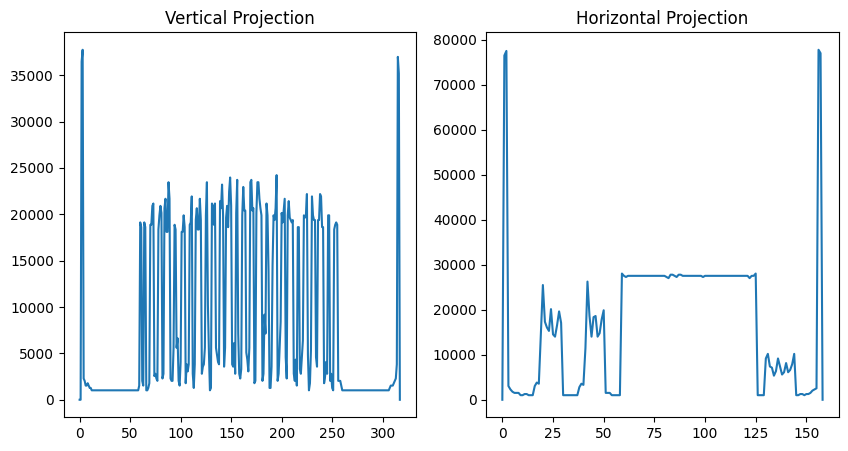

Sinusoidal wave patterns detected. Switching to adaptive thresholding.


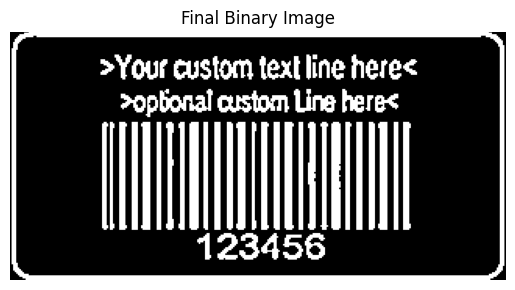

Rotation angle: 90.0


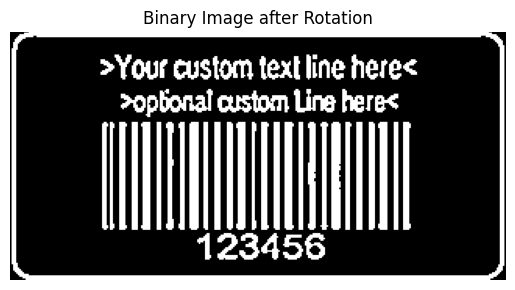

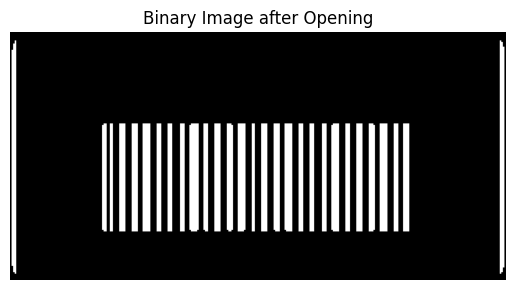

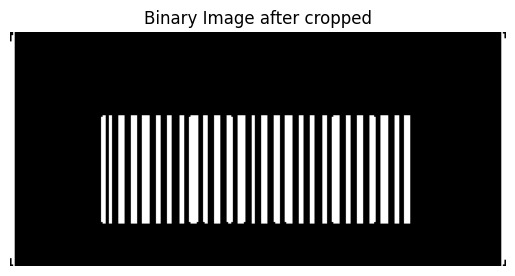

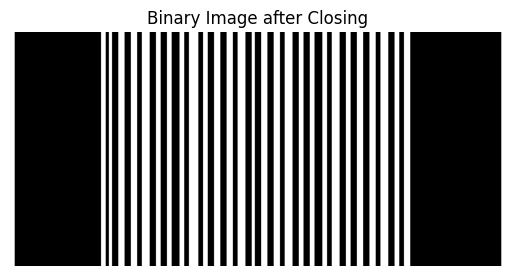

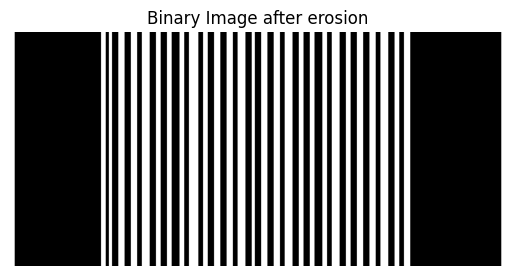

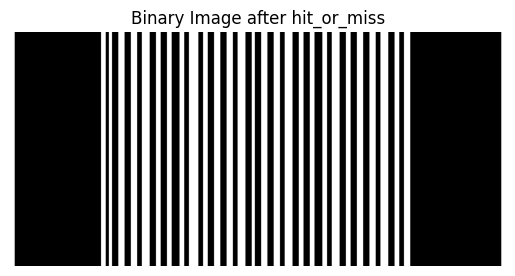

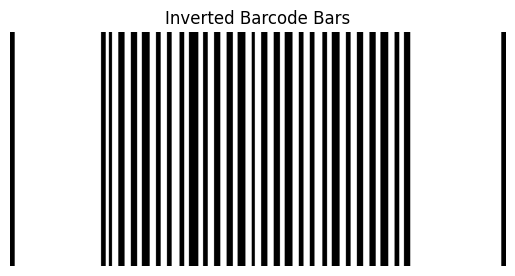

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
def extract_bars_with_erosion(input_path, output_path):
    image = cv2.imread(input_path)
    if image is None:
        raise ValueError("Error: Unable to load image.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initial binary thresholding
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    def check_sinusoidal_patterns(binary_image):
        # Sum projections along vertical and horizontal directions
        vertical_projection = np.sum(binary_image, axis=0)
        horizontal_projection = np.sum(binary_image, axis=1)

        # Detect peaks in projections
        vertical_peaks, _ = find_peaks(vertical_projection, height=np.mean(vertical_projection))
        horizontal_peaks, _ = find_peaks(horizontal_projection, height=np.mean(horizontal_projection))

        # Plot projections for visualization
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(vertical_projection)
        plt.title("Vertical Projection")
        plt.subplot(1, 2, 2)
        plt.plot(horizontal_projection)
        plt.title("Horizontal Projection")
        plt.show()

        # If patterns have significant periodicity, return True
        vertical_periodic = len(vertical_peaks) > 5
        horizontal_periodic = len(horizontal_peaks) > 5

        return vertical_periodic or horizontal_periodic

    # Check if the initial thresholded binary image shows sinusoidal patterns
    if check_sinusoidal_patterns(binary):
        print("Sinusoidal wave patterns detected. Switching to adaptive thresholding.")
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        # Adaptive thresholding for better handling of varying lighting
        binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)
    else:
        print("No sinusoidal wave patterns detected. Continuing with regular thresholding.")
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Visualize the chosen binary image
    plt.imshow(binary, cmap='gray')
    plt.title("Final Binary Image")
    plt.axis('off')
    plt.show()



    # Detect and correct the orientation of the barcode
    coords = np.column_stack(np.where(binary > 0))
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]
    print(f"Rotation angle: {angle}")
    if angle != 90:
        angle = -angle
        (h, w) = binary.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        binary = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        coords = np.column_stack(np.where(binary > 0))
        rect = cv2.minAreaRect(coords)

    # Keep a copy of the binary image before dilation or height-increasing operations
    original_binary = binary.copy()







    # Visualize the binary image after rotation
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Image after Rotation")
    plt.axis('off')
    plt.show()

    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel)


    # Visualize the binary image after opening
    plt.imshow(vertical_lines, cmap='gray')
    plt.title("Binary Image after Opening")
    plt.axis('off')
    plt.show()


    # Find the bounding box of the bars
    x, y, w, h = cv2.boundingRect(vertical_lines)
    # Crop the image to the bounding box
    cropped = vertical_lines[y:y + h, x:x + w]

    # Visualize the binary image after cropping
    plt.imshow(cropped, cmap='gray')
    plt.title("Binary Image after cropped")
    plt.axis('off')
    plt.show()

    # cropped=extract_bars_c(vertical_lines)

    #dilation_kernel=cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60))
    #dilation=cv2.dilate(vertical_lines, dilation_kernel, iterations=10)

    closing_kernel=cv2.getStructuringElement(cv2.MORPH_RECT, (1, 20))
    closing=cv2.morphologyEx(cropped, cv2.MORPH_CLOSE, closing_kernel, iterations=40)

    # Visualize the binary image after closing
    plt.imshow(closing, cmap='gray')
    plt.title("Binary Image after Closing")
    plt.axis('off')
    plt.show()

    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    eroded = cv2.erode(closing, erosion_kernel, iterations=20)

    # Visualize the binary image after erosion
    plt.imshow(eroded, cmap='gray')
    plt.title("Binary Image after erosion")
    plt.axis('off')
    plt.show()

    hit_miss_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 10))
    hit_or_miss = cv2.morphologyEx(eroded, cv2.MORPH_HITMISS, hit_miss_kernel)

    # Visualize the binary image after hit and miss
    plt.imshow(hit_or_miss, cmap='gray')
    plt.title("Binary Image after hit_or_miss")
    plt.axis('off')
    plt.show()

    clean_bars = cv2.bitwise_and(eroded , hit_or_miss)

    inverted_bars = cv2.bitwise_not(clean_bars)

    return inverted_bars


input_path = "/content/dogshit.png"
output_path = "/content/processed_bars.jpg"


clean_bars = extract_bars_with_erosion(input_path, output_path)


plt.imshow(clean_bars, cmap='gray')
plt.title("Inverted Barcode Bars")
plt.axis('off')
plt.show()



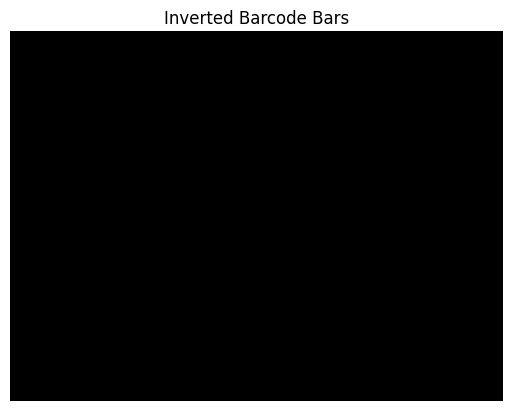

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_bars(input_path, output_path):
    image = cv2.imread(input_path)
    if image is None:
        raise ValueError("Error: Unable to load image.")

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive thresholding for better handling of varying lighting
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Detect and correct the orientation of the barcode
    coords = np.column_stack(np.where(binary > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = binary.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    binary = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Define vertical kernel for detecting vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 70))
    vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel)

    # Erode the image to remove small noise
    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    eroded = cv2.erode(vertical_lines, erosion_kernel, iterations=2)

    # Dilate the bars to fill gaps and make them more solid
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    dilated = cv2.dilate(eroded, dilation_kernel, iterations=2)

    # Remove small noise using connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8)
    sizes = stats[1:, -1]
    min_size = 500  # Minimum size of components to keep
    clean_bars = np.zeros((labels.shape), np.uint8)
    for i in range(0, num_labels - 1):
        if sizes[i] >= min_size:
            clean_bars[labels == i + 1] = 255

    # Invert the image to get white bars on black background
    inverted_bars = cv2.bitwise_not(clean_bars)

    # Save the result
    cv2.imwrite(output_path, inverted_bars)

    return inverted_bars

input_path = "/content/07 - mal7 w felfel.jpg"
output_path = "/content/processed_bars.jpg"

clean_bars = extract_bars(input_path, output_path)

plt.imshow(clean_bars, cmap='gray')
plt.title("Inverted Barcode Bars")
plt.axis('off')
plt.show()


**HERE DETECT CASE 1 2 3 9  11 alooooooo2**


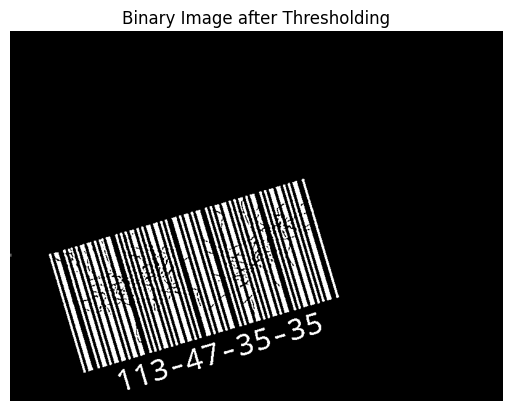

Rotation angle: 14.43372917175293
Rotation angle: -14.43372917175293


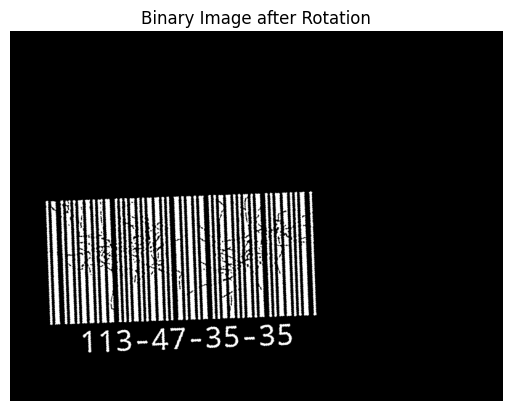

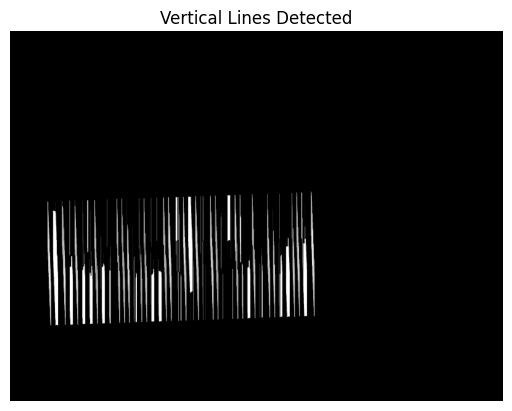

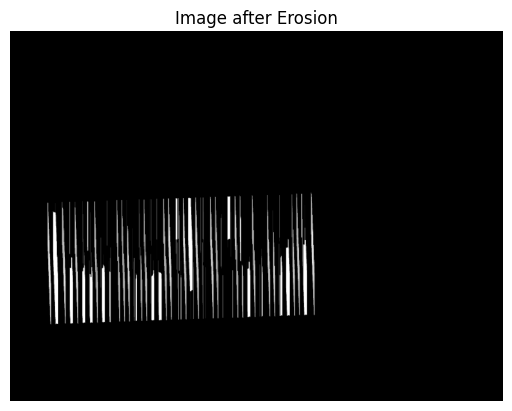

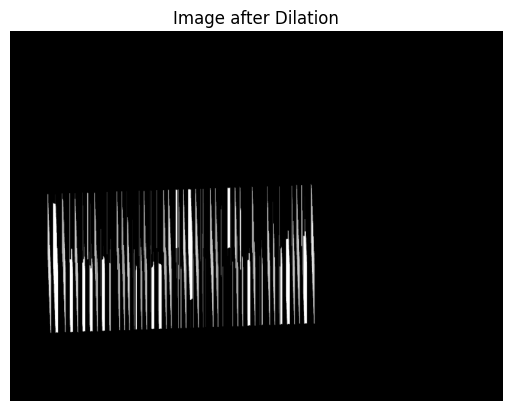

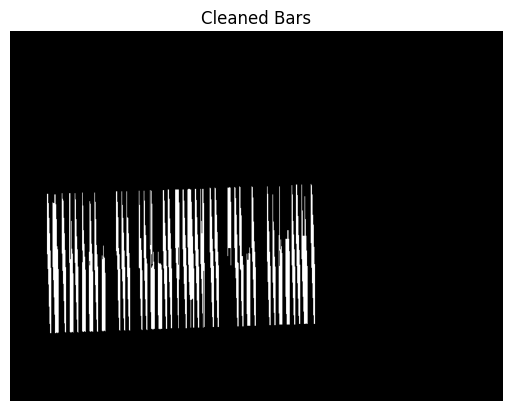

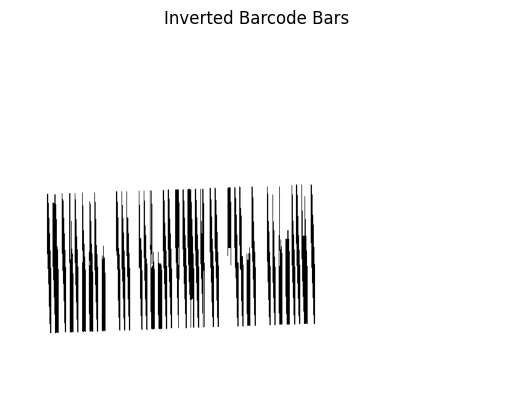

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_bars(input_path, output_path):
    image = cv2.imread(input_path)
    if image is None:
        raise ValueError("Error: Unable to load image.")

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive thresholding for better handling of varying lighting
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Visualize the binary image after thresholding
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Image after Thresholding")
    plt.axis('off')
    plt.show()

    # Detect and correct the orientation of the barcode
    coords = np.column_stack(np.where(binary > 0))
    angle = cv2.minAreaRect(coords)[-1]
    print(f"Rotation angle: {angle}")
    if angle != 90:
        angle = -angle
    else:
        angle = 0

    (h, w) = binary.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    binary = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    print(f"Rotation angle: {angle}")

    # Visualize the binary image after rotation
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Image after Rotation")
    plt.axis('off')
    plt.show()


    # Define vertical kernel for detecting vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 70))
    vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel)

    # Visualize the vertical lines detected
    plt.imshow(vertical_lines, cmap='gray')
    plt.title("Vertical Lines Detected")
    plt.axis('off')
    plt.show()

    # Erode the image to remove small noise
    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    eroded = cv2.erode(vertical_lines, erosion_kernel, iterations=2)

    # Visualize the image after erosion
    plt.imshow(eroded, cmap='gray')
    plt.title("Image after Erosion")
    plt.axis('off')
    plt.show()

    # Dilate the bars to fill gaps and make them more solid
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    dilated = cv2.dilate(eroded, dilation_kernel, iterations=2)

    # Visualize the image after dilation
    plt.imshow(dilated, cmap='gray')
    plt.title("Image after Dilation")
    plt.axis('off')
    plt.show()

    # Remove small noise using connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8)
    sizes = stats[1:, -1]
    min_size = 500  # Minimum size of components to keep
    clean_bars = np.zeros((labels.shape), np.uint8)
    for i in range(0, num_labels - 1):
        if sizes[i] >= min_size:
            clean_bars[labels == i + 1] = 255

    # Visualize the cleaned bars
    plt.imshow(clean_bars, cmap='gray')
    plt.title("Cleaned Bars")
    plt.axis('off')
    plt.show()

    # Invert the image to get white bars on black background
    inverted_bars = cv2.bitwise_not(clean_bars)

    # Save the result
    cv2.imwrite(output_path, inverted_bars)

    return inverted_bars

input_path = "/content/11 - bayza 5ales di bsara7a.jpg"
output_path = "/content/processed_bars.jpg"

clean_bars = extract_bars(input_path, output_path)

plt.imshow(clean_bars, cmap='gray')
plt.title("Inverted Barcode Bars")
plt.axis('off')
plt.show()


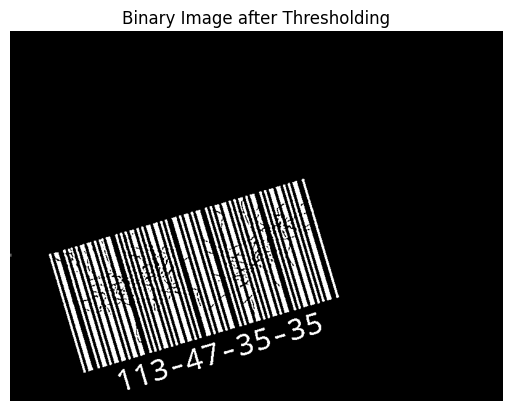

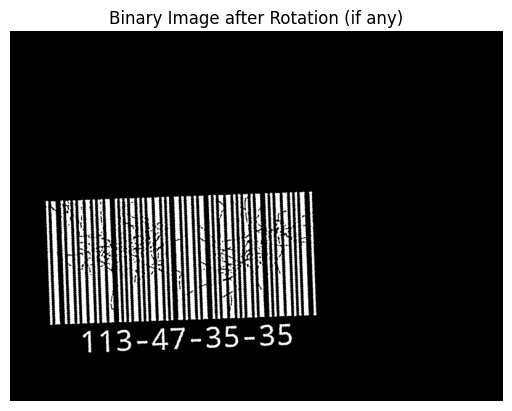

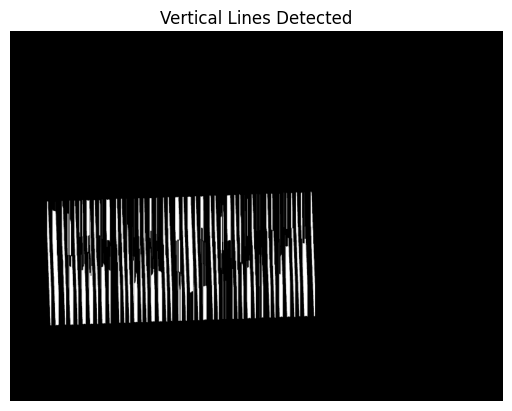

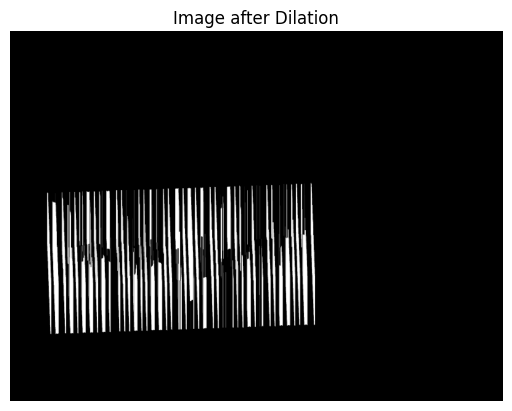

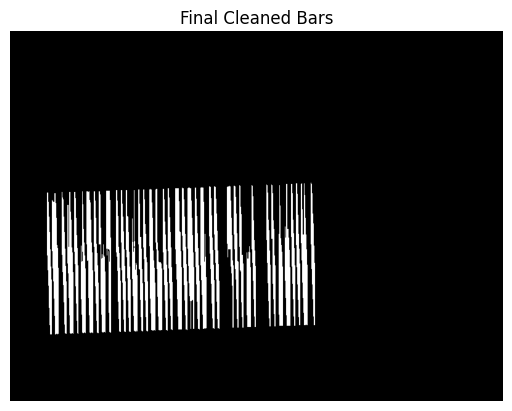

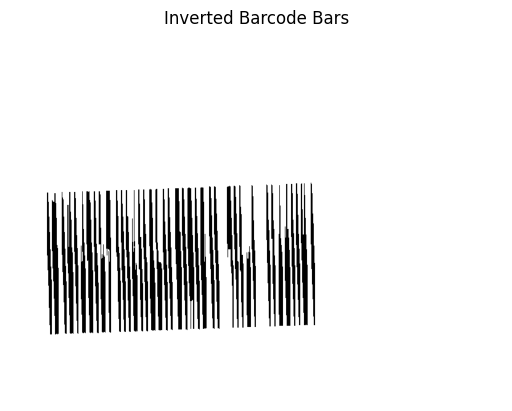

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_bars(input_path, output_path):
    image = cv2.imread(input_path)
    if image is None:
        raise ValueError("Error: Unable to load image.")

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive thresholding for better handling of varying lighting
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Visualize the binary image after thresholding
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Image after Thresholding")
    plt.axis('off')
    plt.show()

    # Detect and correct the orientation of the barcode if needed
    coords = np.column_stack(np.where(binary > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    elif angle > 45:
        angle = 90 - angle
    else:
        angle = -angle

    if abs(angle) > 10:  # Adjust this threshold as needed
        (h, w) = binary.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    else:
        rotated = binary

    # Visualize the binary image after rotation (if any)
    plt.imshow(rotated, cmap='gray')
    plt.title("Binary Image after Rotation (if any)")
    plt.axis('off')
    plt.show()

    # Define vertical kernel for detecting vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    vertical_lines = cv2.morphologyEx(rotated, cv2.MORPH_OPEN, vertical_kernel)

    # Visualize the vertical lines detected
    plt.imshow(vertical_lines, cmap='gray')
    plt.title("Vertical Lines Detected")
    plt.axis('off')
    plt.show()

    # Dilate the bars to fill gaps and make them more solid
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    dilated = cv2.dilate(vertical_lines, dilation_kernel, iterations=2)

    # Visualize the image after dilation
    plt.imshow(dilated, cmap='gray')
    plt.title("Image after Dilation")
    plt.axis('off')
    plt.show()

    # Find contours to filter out noise
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask to draw the valid bars
    mask = np.zeros_like(dilated)

    # Define a minimum area for contours to be considered as valid bars
    min_area = 500 # Adjust this value as needed
    for contour in contours:
        if cv2.contourArea(contour) >= min_area:
            cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)

    # Visualize the final cleaned bars
    plt.imshow(mask, cmap='gray')
    plt.title("Final Cleaned Bars")
    plt.axis('off')
    plt.show()

    # Invert the image to get white bars on black background
    inverted_bars = cv2.bitwise_not(mask)

    # Save the result
    cv2.imwrite(output_path, inverted_bars)

    return inverted_bars

input_path = "/content/11 - bayza 5ales di bsara7a.jpg"
output_path = "/content/processed_bars.jpg"

clean_bars = extract_bars(input_path, output_path)

plt.imshow(clean_bars, cmap='gray')
plt.title("Inverted Barcode Bars")
plt.axis('off')
plt.show()


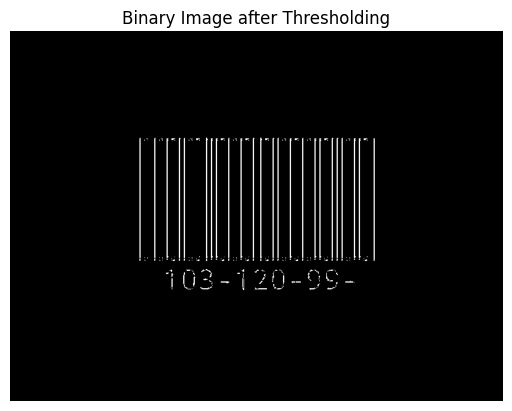

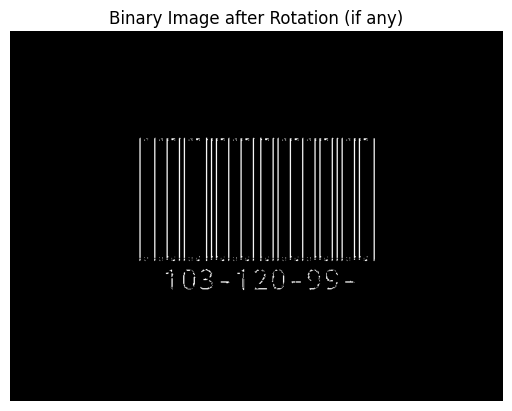

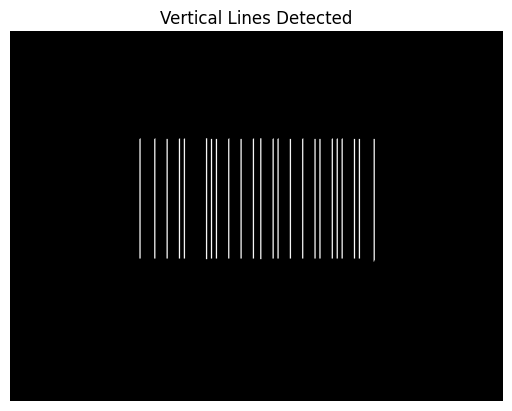

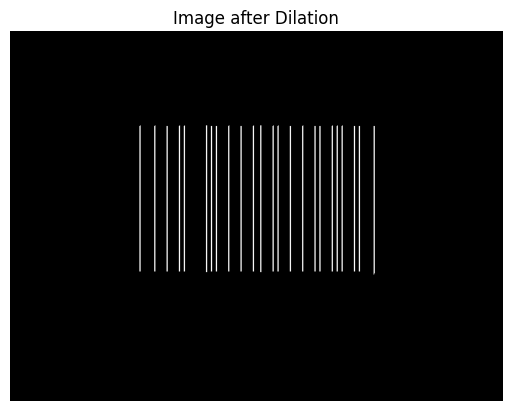

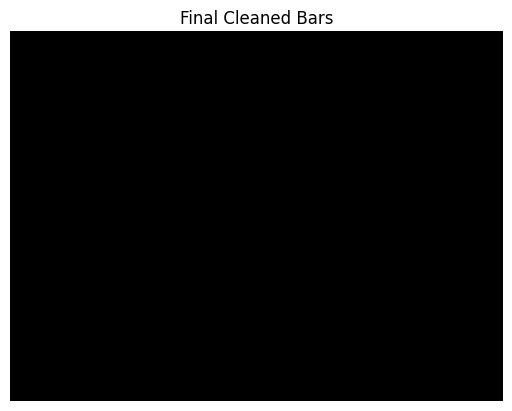

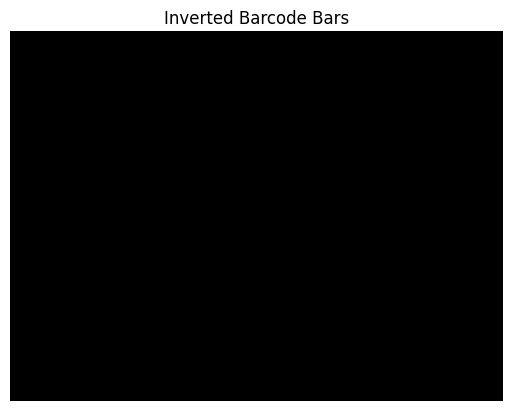

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_bars(input_path, output_path):
    image = cv2.imread(input_path)
    if image is None:
        raise ValueError("Error: Unable to load image.")

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive thresholding for better handling of varying lighting
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Visualize the binary image after thresholding
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Image after Thresholding")
    plt.axis('off')
    plt.show()

    # Detect and correct the orientation of the barcode if needed
    coords = np.column_stack(np.where(binary > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    elif angle > 45:
        angle = 90 - angle
    else:
        angle = -angle

    if abs(angle) > 10:  # Adjust this threshold as needed
        (h, w) = binary.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    else:
        rotated = binary

    # Visualize the binary image after rotation (if any)
    plt.imshow(rotated, cmap='gray')
    plt.title("Binary Image after Rotation (if any)")
    plt.axis('off')
    plt.show()

    # Define vertical kernel for detecting vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    vertical_lines = cv2.morphologyEx(rotated, cv2.MORPH_OPEN, vertical_kernel)

    # Visualize the vertical lines detected
    plt.imshow(vertical_lines, cmap='gray')
    plt.title("Vertical Lines Detected")
    plt.axis('off')
    plt.show()

    # Determine the number of dilation iterations based on image size
    height, width = rotated.shape
    dilation_iterations = max(1, height // 200)  # Adjust the factor as needed

    # Dilate the bars to fill gaps and make them more solid
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    dilated = cv2.dilate(vertical_lines, dilation_kernel, iterations=dilation_iterations)

    # Visualize the image after dilation
    plt.imshow(dilated, cmap='gray')
    plt.title("Image after Dilation")
    plt.axis('off')
    plt.show()

    # Find contours to filter out noise
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask to draw the valid bars
    mask = np.zeros_like(dilated)

    # Define a minimum area for contours to be considered as valid bars based on image size
    min_area = (height * width) // 500  # Adjust this factor as needed
    for contour in contours:
        if cv2.contourArea(contour) >= min_area:
            cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)

    # Visualize the final cleaned bars
    plt.imshow(mask, cmap='gray')
    plt.title("Final Cleaned Bars")
    plt.axis('off')
    plt.show()

    # Invert the image to get white bars on black background
    inverted_bars = cv2.bitwise_not(mask)

    # Save the result
    cv2.imwrite(output_path, inverted_bars)

    return inverted_bars

input_path = "/content/10 - wen el kontraastttt.jpg"
output_path = "/content/processed_bars.jpg"

clean_bars = extract_bars(input_path, output_path)

plt.imshow(clean_bars, cmap='gray')
plt.title("Inverted Barcode Bars")
plt.axis('off')
plt.show()


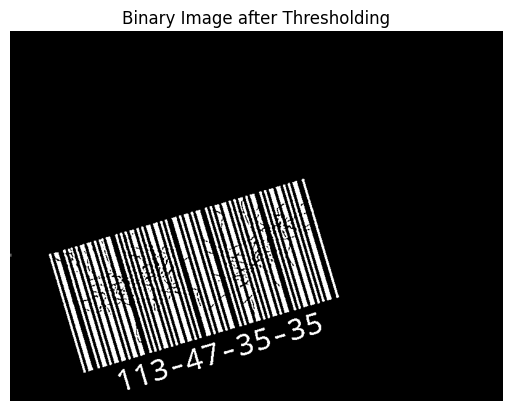

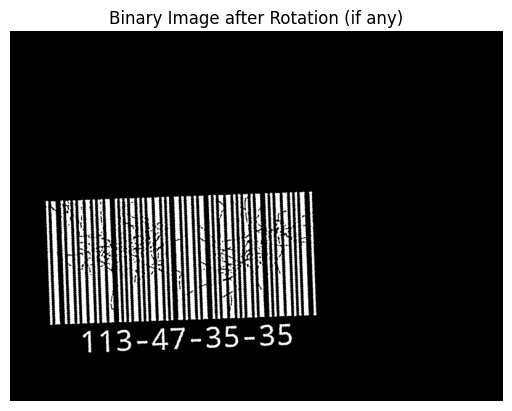

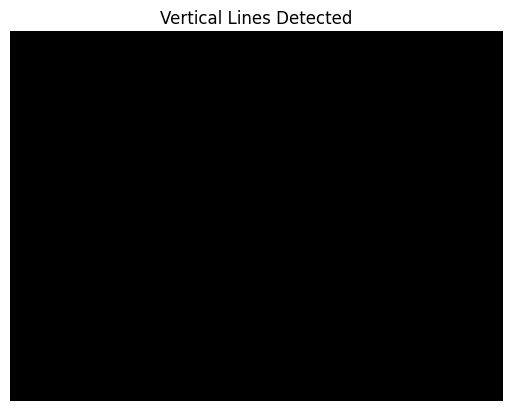

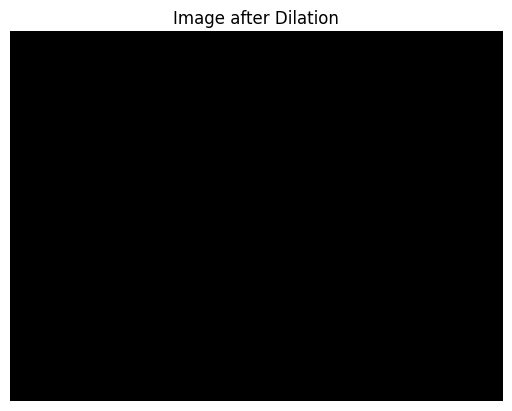

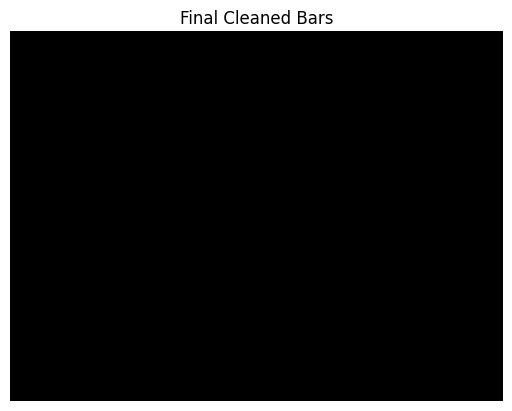

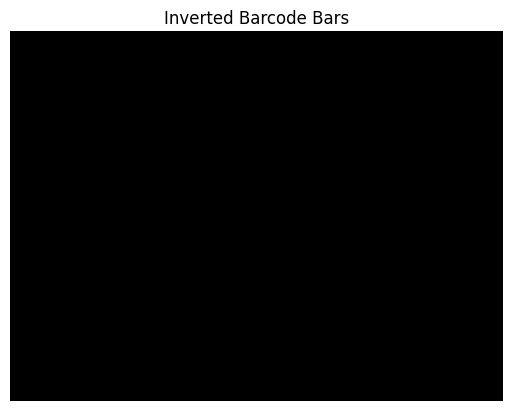

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

def extract_bars_with_erosion(input_path, output_path):
    image = cv2.imread(input_path)
    if image is None:
        raise ValueError("Error: Unable to load image.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive thresholding for better handling of varying lighting
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    # Visualize the binary image after thresholding
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Image after Thresholding")
    plt.axis('off')
    plt.show()

    # Detect and correct the orientation of the barcode if needed
    coords = np.column_stack(np.where(binary > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    elif angle > 45:
        angle = 90 - angle
    else:
        angle = -angle

    if abs(angle) > 10:  # Adjust this threshold as needed
        (h, w) = binary.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    else:
        rotated = binary

    # Visualize the binary image after rotation (if any)
    plt.imshow(rotated, cmap='gray')
    plt.title("Binary Image after Rotation (if any)")
    plt.axis('off')
    plt.show()


    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel)

     # Visualize the vertical lines detected
    plt.imshow(vertical_lines, cmap='gray')
    plt.title("Vertical Lines Detected")
    plt.axis('off')
    plt.show()

    # Dilate the bars to fill gaps and make them more solid
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    dilated = cv2.dilate(vertical_lines, dilation_kernel, iterations=2)

    # Visualize the image after dilation
    plt.imshow(dilated, cmap='gray')
    plt.title("Image after Dilation")
    plt.axis('off')
    plt.show()


    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    eroded = cv2.erode(vertical_lines, erosion_kernel, iterations=2)

    hit_miss_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 10))
    hit_or_miss = cv2.morphologyEx(eroded, cv2.MORPH_HITMISS, hit_miss_kernel)

    # Find contours to filter out noise
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask to draw the valid bars
    mask = np.zeros_like(dilated)

    # Define a minimum area for contours to be considered as valid bars
    min_area = 500 # Adjust this value as needed
    for contour in contours:
        if cv2.contourArea(contour) >= min_area:
            cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)

    # Visualize the final cleaned bars
    plt.imshow(mask, cmap='gray')
    plt.title("Final Cleaned Bars")
    plt.axis('off')
    plt.show()

    clean_bars = cv2.bitwise_and(eroded, hit_or_miss)

    inverted_bars = cv2.bitwise_not(clean_bars)

    cv2.imwrite(output_path, inverted_bars)

    return inverted_bars

input_path = "/content/11 - bayza 5ales di bsara7a.jpg"
output_path = "/content/processed_bars.jpg"


clean_bars = extract_bars_with_erosion(input_path, output_path)


plt.imshow(clean_bars, cmap='gray')
plt.title("Inverted Barcode Bars")
plt.axis('off')
plt.show()


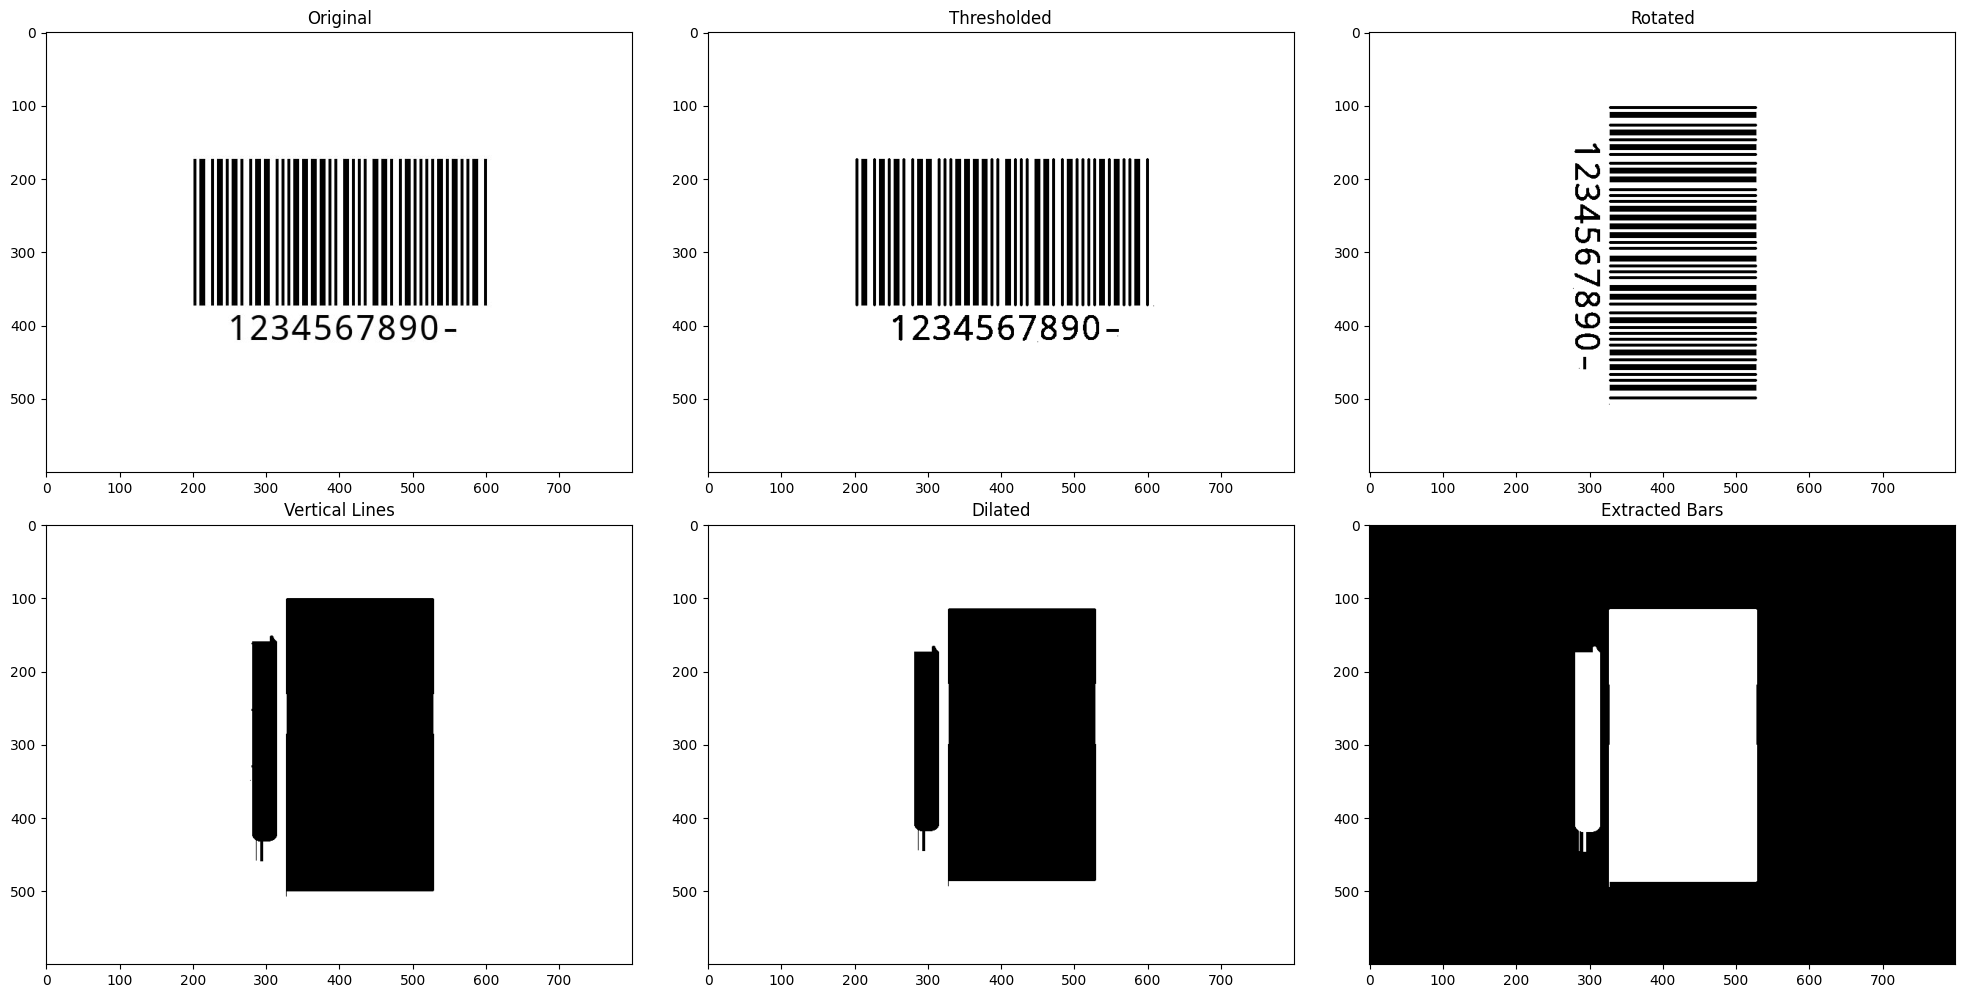

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_bars(input_path, output_path):
    image = cv2.imread(input_path)
    if image is None:
        raise ValueError("Error: Unable to load image.")

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Try both adaptive thresholding and Otsu's method
    binary_adaptive = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY_INV, 11, 2)
    _, binary_otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Combine both binary images
    binary = cv2.bitwise_or(binary_adaptive, binary_otsu)

    # Visualize the binary image after thresholding
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(binary_adaptive, cmap='gray'), plt.title('Adaptive Thresholding')
    plt.subplot(122), plt.imshow(binary_otsu, cmap='gray'), plt.title('Otsu Thresholding')
    plt.show()

    # Detect and correct the orientation of the barcode if needed
    coords = np.column_stack(np.where(binary > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    elif angle > 45:
        angle = 90 - angle
    else:
        angle = -angle

    if abs(angle) > 10:  # Adjust this threshold as needed
        (h, w) = binary.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    else:
        rotated = binary

    # Visualize the binary image after rotation (if any)
    plt.imshow(rotated, cmap='gray')
    plt.title("Binary Image after Rotation (if any)")
    plt.axis('off')
    plt.show()

    # Define vertical kernel for detecting vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    vertical_lines = cv2.morphologyEx(rotated, cv2.MORPH_OPEN, vertical_kernel)

    # Visualize the vertical lines detected
    plt.imshow(vertical_lines, cmap='gray')
    plt.title("Vertical Lines Detected")
    plt.axis('off')
    plt.show()

    # Erode to thin out the lines
    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    eroded = cv2.erode(vertical_lines, erosion_kernel, iterations=2)

    # Use hit-or-miss to remove small artifacts
    hit_miss_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 10))
    hit_or_miss = cv2.morphologyEx(eroded, cv2.MORPH_HITMISS, hit_miss_kernel)

    # Combine eroded image with hit
        # Combine eroded image with hit-or-miss result
    result = cv2.bitwise_and(eroded, cv2.bitwise_not(hit_or_miss))

    # Dilate to make the lines more visible
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
    dilated = cv2.dilate(result, dilation_kernel, iterations=1)

    # Visualize the final result
    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(image), plt.title('Original Image')
    plt.subplot(132), plt.imshow(rotated, cmap='gray'), plt.title('Binary Image')
    plt.subplot(133), plt.imshow(dilated, cmap='gray'), plt.title('Extracted Bars')
    plt.show()

    # Save the result
    cv2.imwrite(output_path, dilated)
    print(f"Extracted bars saved to {output_path}")

# Usage example
input_image_path = "/content/03 - eda ya3am ew3a soba3ak mathazarsh.jpg"
output_image_path = "/content/processed_barcode.jpg"

try:
    extract_bars(input_image_path, output_image_path)
except Exception as e:
    print(f"An error occurred: {str(e)}")


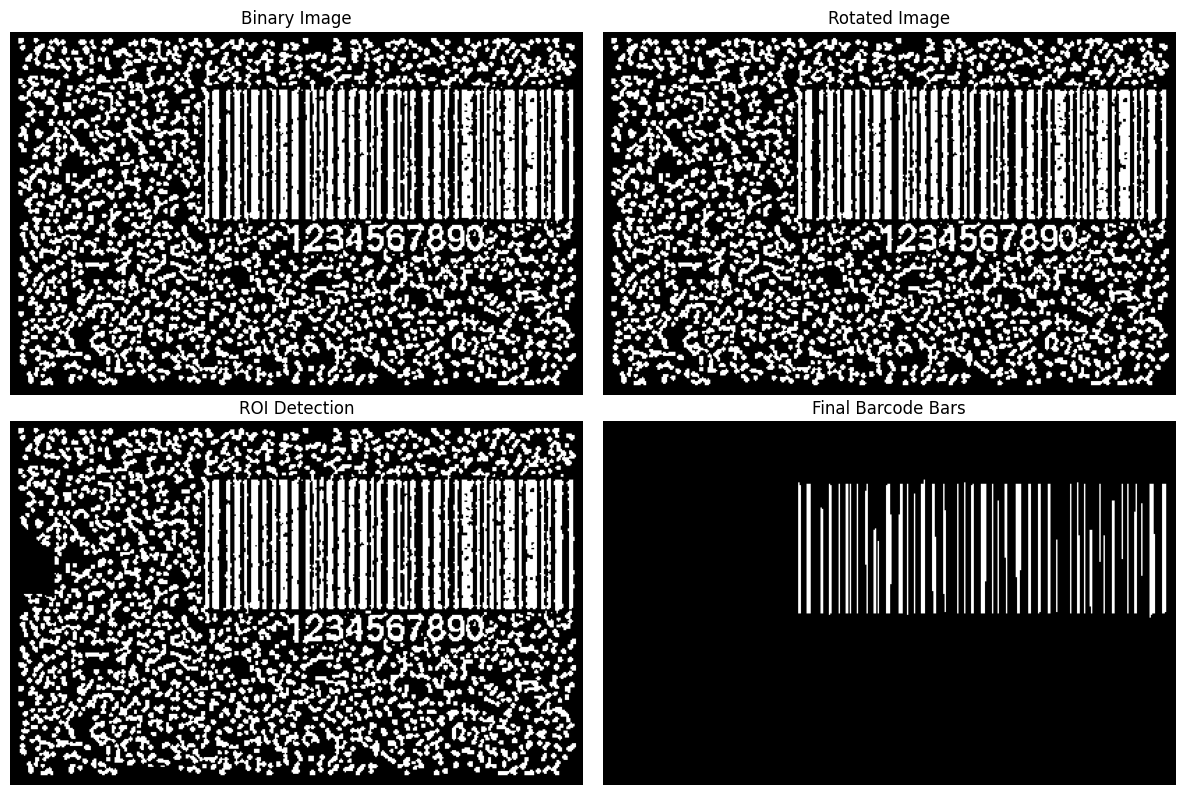

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def enhanced_bar_detection(image_path):
    # Step 1: Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Error: Unable to load image.")

    # Step 2: Noise reduction using Gaussian Blur
    denoised = cv2.GaussianBlur(image, (5, 5), 0)

    # Step 3: Adaptive thresholding for binarization
    binary = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 3)

    # Step 4: Detect barcode orientation
    coords = np.column_stack(np.where(binary > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    elif angle > 45:
        angle = 90 - angle
    else:
        angle = -angle

    # Correct orientation if the angle is significant
    (h, w) = binary.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Step 5: Refine ROI detection with additional noise filtering
    edges = cv2.Canny(rotated, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
    roi_mask = np.zeros_like(rotated)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(roi_mask, (x1, y1), (x2, y2), 255, 2)

    roi_dilated = cv2.dilate(roi_mask, cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15)), iterations=2)
    barcode_region = cv2.bitwise_and(rotated, rotated, mask=roi_dilated)

    # Step 6: Extract vertical lines using morphology
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    vertical_lines = cv2.morphologyEx(barcode_region, cv2.MORPH_OPEN, vertical_kernel)

    # Step 7: Dynamically fill gaps in fragmented bars
    # Step 7: Dynamically fill gaps in fragmented bars

    # Detect connected vertical line segments (from Step 6)
    contours, _ = cv2.findContours(vertical_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate average bar width and spacing
    bar_widths = []
    bar_spacings = []
    prev_x = None

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bar_widths.append(w)
        if prev_x is not None:
            bar_spacings.append(x - prev_x)
        prev_x = x

    # Use median to handle outliers
    if bar_widths and bar_spacings:
        avg_bar_width = int(np.median(bar_widths))
        avg_spacing = int(np.median(bar_spacings))
    else:
        avg_bar_width = 1
        avg_spacing = 1

    # Dynamically set kernel size based on average bar width and spacing
    dynamic_kernel_width = max(1, avg_spacing)  # Minimum kernel width is 1
    dynamic_kernel_height = max(10, avg_bar_width * 15)  # Scale height proportionally

    # Create dynamic closing kernel
    closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dynamic_kernel_width, dynamic_kernel_height))

    # Apply closing to fill gaps
    closed = cv2.morphologyEx(vertical_lines, cv2.MORPH_CLOSE, closing_kernel)



    # Step 8: Contour-based filtering to extract valid bars
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(closed)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = h / float(w)
        if aspect_ratio > 4:  # Filter for valid bar shapes
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Step 9: Final cleaning
    final_bars = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, closing_kernel)

    return binary, rotated, barcode_region, final_bars

# Path to the test image
image_path = '/content/alooooooooo2.jpg.png'

# Apply the enhanced barcode detection
binary_image, rotated_image, roi_image, refined_bars = enhanced_bar_detection(image_path)

# Display the results
plt.figure(figsize=(12, 8))
titles = ['Binary Image', 'Rotated Image', 'ROI Detection', 'Final Barcode Bars']
images = [binary_image, rotated_image, roi_image, refined_bars]

for i, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_fourier_transform(image):
    """Remove vertical black-and-white noise using Fourier Transform."""
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Input to Fourier Transform must be a color (BGR) image.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Create a mask to remove high-frequency vertical lines
    rows, cols = gray.shape
    mask = np.ones((rows, cols, 2), np.uint8)
    center_row, center_col = rows // 2, cols // 2
    mask[:, center_col - 10:center_col + 10] = 0  # Remove vertical frequencies

    # Apply mask and inverse DFT
    dft_shift_filtered = dft_shift * mask
    dft_inverse = np.fft.ifftshift(dft_shift_filtered)
    filtered_image = cv2.idft(dft_inverse)
    filtered_image = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])
    return cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def correct_orientation(image):
    """Correct skewed orientation using Hough Line Transform."""
    # Ensure the input is a valid grayscale or color image
    if len(image.shape) == 2:  # Already grayscale
        gray = image
    elif len(image.shape) == 3 and image.shape[2] == 3:  # Convert BGR to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image format for orientation correction.")

    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Detect lines using Hough Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    if lines is not None:
        angles = []
        for rho, theta in lines[:, 0]:
            angle = np.rad2deg(theta) - 90
            if -45 <= angle <= 45:  # Filter out steep angles
                angles.append(angle)
        if angles:
            median_angle = np.median(angles)
            # Rotate the image to correct the skew
            height, width = gray.shape
            rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), median_angle, 1)
            corrected_image = cv2.warpAffine(image, rotation_matrix, (width, height))
            return corrected_image

    return image  # Return original if no lines are found

def enhance_contrast(image):
    """Enhance image contrast using CLAHE."""
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 2:
        gray = image
    else:
        raise ValueError("Unexpected image format for contrast enhancement.")

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

def extract_bars_with_enhancements(input_path, output_path):
    # Step 1: Load the image
    image = cv2.imread(input_path)
    if image is None:
        raise ValueError(f"Error: Unable to load image at path {input_path}. Please check the file path.")

    # Step 2: Apply Fourier Transform to remove vertical noise
    try:
        image = apply_fourier_transform(image)
    except ValueError as e:
        print(f"Fourier Transform Error: {e}")
        return None

    # Step 3: Correct orientation if needed
    try:
        image = correct_orientation(image)
    except ValueError as e:
        print(f"Orientation Correction Error: {e}")
        return None

    # Step 4: Enhance contrast
    enhanced_contrast = enhance_contrast(image)

    # Step 5: Apply adaptive thresholding
    binary = cv2.adaptiveThreshold(
        enhanced_contrast, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Step 6: Extract vertical lines using morphological operations
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel)

    # Step 7: Refine bars by applying erosion
    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
    eroded = cv2.erode(vertical_lines, erosion_kernel, iterations=2)

    # Step 8: Extract rectangular bar regions using contours
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    height, width = enhanced_contrast.shape
    mask = np.zeros_like(eroded)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = h / (w + 1e-5)  # Avoid division by zero
        if aspect_ratio > 5 and h > 0.2 * height:  # Adjust thresholds for bars
            cv2.rectangle(mask, (x, y), (x + w, y + h), 255, thickness=cv2.FILLED)

    # Step 9: Invert the mask to get the final result
    inverted_bars = cv2.bitwise_not(mask)

    # Step 10: Save the output
    cv2.imwrite(output_path, inverted_bars)

    return inverted_bars

# Input and output paths for processing
input_paths = [
    "/content/07 - mal7 w felfel.jpg",
    "/content/08 - compresso espresso.jpg",
    "/content/09 - e3del el soora ya3ammm.jpg"
]
output_paths = [
    "/mnt/data/processed_bars_09.jpg",
    "/mnt/data/processed_bars_11.jpg",
    "/mnt/data/processed_bars_03.jpg"
]

# Process each image and visualize the results
for input_path, output_path in zip(input_paths, output_paths):
    try:
        clean_bars = extract_bars_with_enhancements(input_path, output_path)
        if clean_bars is not None:
            plt.figure()
            plt.imshow(clean_bars, cmap='gray')
            plt.title(f"Processed: {output_path.split('/')[-1]}")
            plt.axis('off')
    except ValueError as e:
        print(e)

plt.show()


NameError: name 'apply_fourier_transform' is not defined

Not enough barcodes detected in the image.


<ipython-input-126-0f4b376f51da>:75: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.boxPoints(rect))
<ipython-input-126-0f4b376f51da>:77: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box1 = np.int0(cv2.boxPoints(rect1))


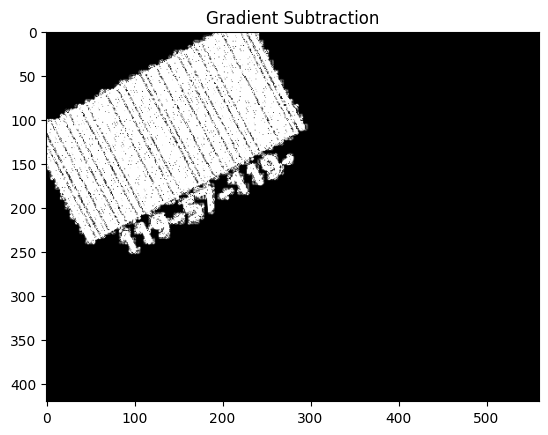

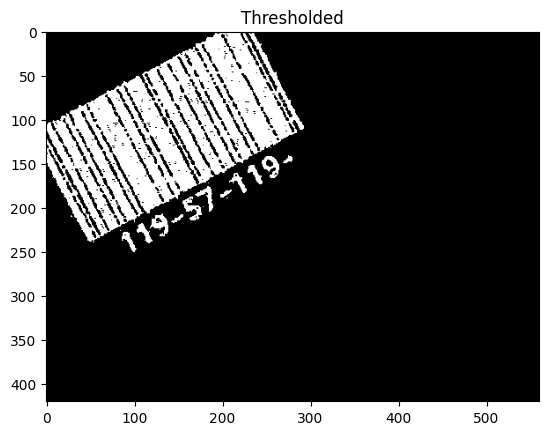

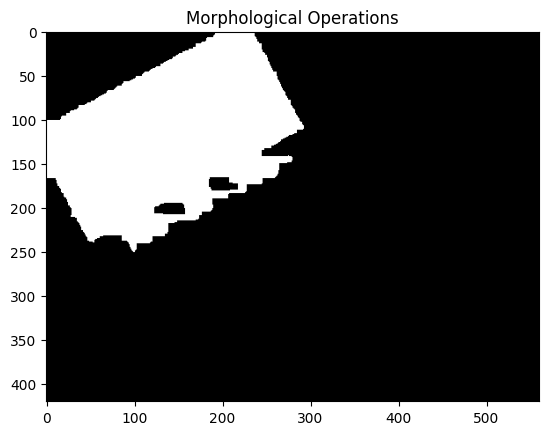

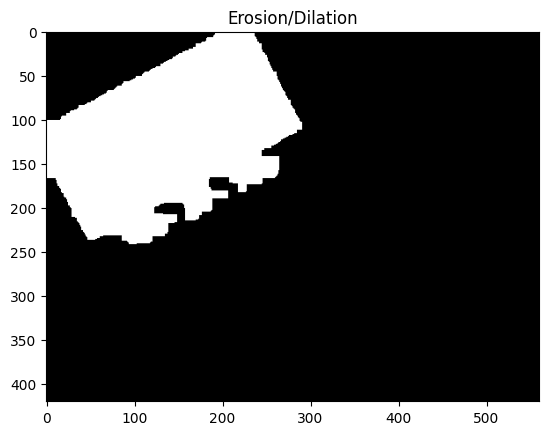

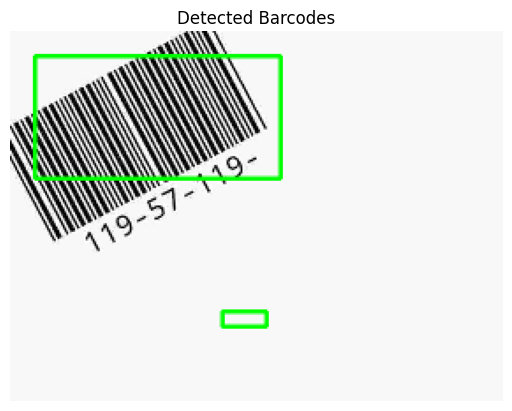

In [ ]:
# import the necessary packages
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt


# load the image and convert it to grayscale
image = cv2.imread("/content/09 - e3del el soora ya3ammm.jpg")

# resize image
image = cv2.resize(image, None, fx=0.7, fy=0.7, interpolation=cv2.INTER_CUBIC)

# convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# calculate x & y gradient
gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)

# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)


plt.figure()
plt.title("Gradient Subtraction")
plt.imshow(gradient, cmap="gray")

# blur the image
blurred = cv2.blur(gradient, (3, 3))

# threshold the image
_, thresh = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)


plt.figure()
plt.title("Thresholded")
plt.imshow(thresh, cmap="gray")

# construct a closing kernel and apply it to the thresholded image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)


plt.figure()
plt.title("Morphological Operations")
plt.imshow(closed, cmap="gray")

# perform a series of erosions and dilations
closed = cv2.erode(closed, None, iterations=4)
closed = cv2.dilate(closed, None, iterations=4)

plt.figure()
plt.title("Erosion/Dilation")
plt.imshow(closed, cmap="gray")

# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts, hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]

# Check if enough contours are found before accessing them
if len(cnts) > 1:  # Check for at least 2 contours
    # Sort and select the largest two contours
    c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
    c1 = sorted(cnts, key=cv2.contourArea, reverse=True)[1]

    # ... (rest of the code to process c and c1) ...

else:
    print("Not enough barcodes detected in the image.")

# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = np.int0(cv2.boxPoints(rect))
rect1 = cv2.minAreaRect(c1)
box1 = np.int0(cv2.boxPoints(rect1))

# draw a bounding box around the detected barcodes
cv2.drawContours(image, [box], -1, (0, 255, 0), 3)
cv2.drawContours(image, [box1], -1, (0, 255, 0), 3)

# Resize the image for display
image = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)

# Display the final image with bounding boxes
plt.figure()
plt.title("Detected Barcodes")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper Matplotlib display
plt.axis("off")
plt.show()


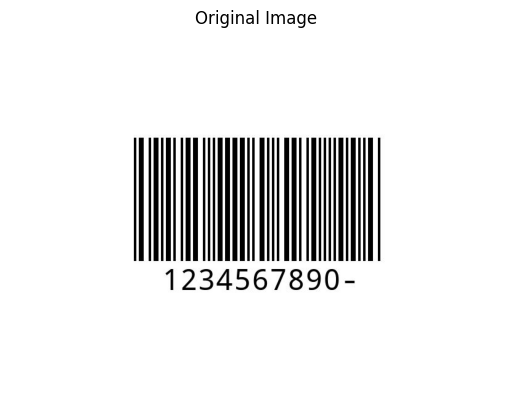

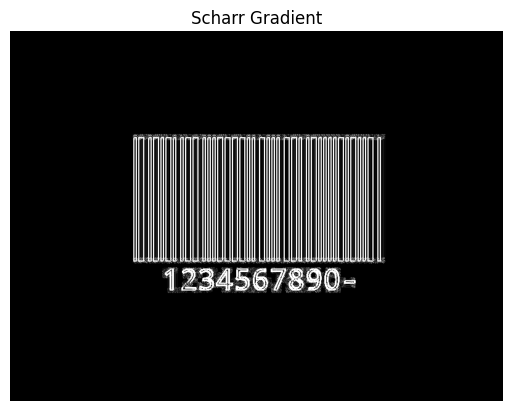

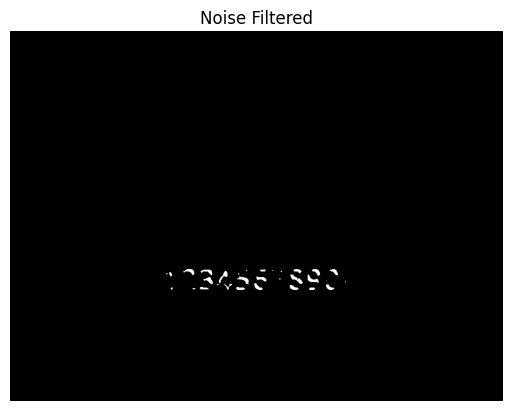

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


class BarCodeDector:
    """
    Detects bar codes in the given image, draws a border around them.

    Algorithm outline:
        1. Scharr gradient in x and y direction
        2. Subtract y from x gradient for finding barcode region
        3. Blur and threshold
        4. Closing kernel
        5. Series of dilations and erosions
        6. Largest contour should be the barcode
    """
    def __init__(self, image_path: str, border_color: str):
        if not image_path:
            raise ValueError("Expected 'image_path' to be a value, not None")
        self.image_path = image_path
        self.border_color = self.string_rgb_to_color(border_color)

    def string_rgb_to_color(self, rgb_fmt: str) -> tuple[int, int, int]:
        """
        Converts 'r:g:b' format to a tuple (r, g, b) of type int.
        """
        c = rgb_fmt.split(":")
        if len(c) != 3:
            raise ValueError("Expected 'border_color' format to be 'r:g:b', each value between 0 and 255")
        try:
            c = [int(x) for x in c]
        except ValueError:
            raise ValueError("Expected color channel in 'border_color' to be parsable as a number")
        return tuple(c)

    def show_image(self, image, title="Image"):
        """
        Displays the image via matplotlib.
        """
        if len(image.shape) == 2:  # Grayscale image
            plt.imshow(image, cmap='gray')
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            plt.imshow(image)
        plt.axis('off')
        plt.title(title)
        plt.show()

    def sharr_gradient(self, image):
        """
        Applies the Scharr gradient to the given image.
        """
        x_gradient = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
        y_gradient = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
        result = cv2.subtract(x_gradient, y_gradient)
        return cv2.convertScaleAbs(result)  # Converts to 8-bit image

    def filter_noise(self, image):
        """
        Filters noise from the given image by applying Gaussian blur and thresholding.
        """
        blur = cv2.GaussianBlur(image, (9, 9), 0)
        # Adjusted threshold value to be more lenient
        _, thresh = cv2.threshold(blur, 200, 255, cv2.THRESH_BINARY)
        return thresh

    def closing_kernel(self, image):
        """
        Applies a closing operation with a rectangular kernel.
        """
        # Adjusted kernel size to potentially capture more barcode features
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    def closing_kernel(self, image):
        """
        Applies a closing operation with a rectangular kernel.
        """
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (29, 29))
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    def eroding_dilation(self, image):
        """
        Applies erosion followed by dilation to remove noise and refine regions.
        """
        image = cv2.erode(image, None, iterations=4)
        return cv2.dilate(image, None, iterations=4)

    def contours(self, image):
        """
        Finds the largest contour in the image, assumed to be the barcode.
        """
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        c = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        return np.intp(box)

    def draw_box(self, image, box):
        """
        Draws a bounding box around the barcode using the detected contours.
        """
        return cv2.drawContours(image, [box], -1, self.border_color, 3)

    def process(self):
        """
        Processes the image to detect and highlight a barcode.
        """
        original_image = cv2.imread(self.image_path)
        if original_image is None:
            raise ValueError(f"Unable to read the image at path: {self.image_path}")

        self.show_image(original_image, "Original Image")

        gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

        gradient_image = self.sharr_gradient(gray_image)
        self.show_image(gradient_image, "Scharr Gradient")

        noise_filtered_image = self.filter_noise(gradient_image)
        self.show_image(noise_filtered_image, "Noise Filtered")

        closed_image = self.closing_kernel(noise_filtered_image)
        self.show_image(closed_image, "After Closing Kernel")

        refined_image = self.eroding_dilation(closed_image)
        self.show_image(refined_image, "After Erosion and Dilation")

        barcode_contours = self.contours(refined_image)
        result_image = self.draw_box(original_image.copy(), barcode_contours)
        self.show_image(result_image, "Detected Barcode")


if __name__ == "__main__":
    # Get user inputs
    # image_path = input("/content/01 - lol easy.jpg ").strip() # The original line had the path in the input function
    image_path = "/content/01 - lol easy.jpg"  # Assign the path directly
    # border_color = input("Enter the border color (r:g:b format): ").strip() # This line was causing the error
    border_color = "0:255:0"  # Provide a default border color in 'r:g:b' format

    # Process the image
    detector = BarCodeDector(image_path, border_color)
    detector.process()